<a href="https://colab.research.google.com/github/LarrySnyder/RLforInventory/blob/main/notebooks/4a_MPNV_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DQN for the Multi-Period Newsvendor Problem (MPNV)

---
> **Note:** This file is read-only. To work with it, you first need to save a copy to your Google Drive:
> 
> 1. Go to the File menu. (The File menu inside the notebook, right below Intro to Jupyter—not the File menu in your browser, at the top of your screen.)
> 2. Choose Save a copy in Drive. (Log in to your Google account, if necessary.) Feel free to move it to a different folder in your Drive, if you want.
> 3. Colab should open up a new browser tab with your copy of the notebook. Double-click the filename at the top of the window and rename it Intro to Jupyter [your name(s)].
> 4. Close the original read-only notebook in your browser.
---

---
> This notebook is part of the *Summer Bootcamp at Kellogg: RL in Operations* workshop at Northwestern University, August 2022. The notebooks are for Day 4, taught by Profs. Larry Snyder, Lehigh University.
---

In this notebook, we'll implement a simple DQN approach for solving the MPNV. We'll use the OpenAI `gym` package to define and manage our MPNV environment, and we'll use Tensorflow to do the deep RL.

This notebook is just a demonstration; there are no exercises. Instead, you'll use it as a model to build a DQN approach for the beer game problem in the next notebook.

The code used in this notebook is based on the approach outlined in the blog post "[Building a Reinforcement Learning Environment using OpenAI Gym](https://www.section.io/engineering-education/building-a-reinforcement-learning-environment-using-openai-gym/)" by Lilian Tonia.

### Preliminary Python Stuff

First we'll install the Python packages we need that are not pre-installed in Colab. The `pip install` commands below worked for me; I hope they work for you. I recommend not modifying the version numbers in the commands. Once you start tinkering with the dependencies, things can get messy. (Take my word for it.) 

In [ ]:
!pip install tensorflow==2.8.2
!pip install gym==0.23
!pip install keras==2.8.0
!pip install keras-rl2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 624 kB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697660 sha256=ad50184150925737a75b6143501ad10f22bf2360bfd83639f0fb5c5c5d0a3ab4
  Stored in directory: /root/.cache/pip/wheels/f0/7e/16/4d727df048fdb96518ec5c02266e55b98bc398837353852a6a
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 756 kB/s 


In [ ]:
!pip install stockpyl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 146 kB 4.3 MB/s 
     |████████████████████████████████| 3.1 MB 56.0 MB/s 
     |████████████████████████████████| 2.8 MB 28.4 MB/s 
     |████████████████████████████████| 512 kB 50.9 MB/s 
     |████████████████████████████████| 90 kB 10.3 MB/s 
     |████████████████████████████████| 100 kB 12.2 MB/s 
     |████████████████████████████████| 84 kB 4.0 MB/s 
     |████████████████████████████████| 121 kB 62.3 MB/s 
     |████████████████████████████████| 109 kB 60.8 MB/s 
     |████████████████████████████████| 118 kB 55.6 MB/s 
     |████████████████████████████████| 128 kB 56.7 MB/s 
     |████████████████████████████████| 126 kB 59.4 MB/s 
     |████████████████████████████████| 112 kB 75.2 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 399 kB 51.7 MB/s 
     |███████████████████████████████

Next, we'll import the packages we need.

In [ ]:
import numpy as np
from gym import Env
from gym.spaces import Discrete
import random
import matplotlib.pyplot as plt

In [ ]:
from stockpyl import sim
from stockpyl.supply_chain_network import single_stage_system

### MPNV Environment

The code below defines an environment for the MPNV. This class is identical to the `MPNVEnv` class we defined in the "RL for MPNV" notebook, except:

* The class is subclassed from the `gym.Env` class.
* There is no `gamma` parameter. (We'll assume no discounting.)
* The `__init__()` method defines the `action_space` and `observation_space` (aka state space) using datatypes provided by `gym`. These are a little annoying to query, so we also define `action_space_list` and `observation_space_list` as simple lists that can be accessed when needed.
* There is no `allowable_actions` attribute. All actions are considered allowable for every state, but actions that bring the inventory level above `state_max` just bring the IL to `state_max`. 
* There are no methods to get actions (e.g., `get_epsilon_greedy_action()`. Tensorflow will handle this for us.

In [ ]:
class MPNVEnv(Env):
	"""Multi-period newsvendor (MPNV) problem environment. A state represents an inventory level. 
	An action is an order quantity.

	Parameters
	----------
	network : SupplyChainNetwork
		The network to simulate.
	episode_length : int
		The number of periods in one episode.
	min_state : int
		The minimum value of the state space to consider.
	max_state : int
		The maximum value of the state space to consider.
	"""

	def __init__(self, network, episode_length: int, min_state: int, max_state: int):

		self.action_space = Discrete(max_state + 1)
		self.observation_space = Discrete(max_state - min_state + 1, start=min_state)
		# for convenience
		self.action_space_list = list(range(max_state + 1))
		self.observation_space_list = list(range(min_state, max_state + 1))

		# Store problem data.
		self.network = network
		self.episode_length = episode_length
		self.min_state = min_state
		self.max_state = max_state

		# Initial states are the non-negative states. (Of course it's possible to start with a negative
		# IL, but let's keep things simpler.)
		self.initial_states = list(range(max_state + 1))

		# Initialize current state info.
		self.state = None

		# Get a shortcut to the (single) node in the network, for convenience.
		self.node = network.nodes[0]

	def reset(self):
		"""Reset the environment and the simulation. Choose an initial state randomly from
		the list of possible initial states. Return it and set it in self.inventory_level."""

		# Determine initial IL and store it in environment's state.
		initial_state = np.random.choice(self.initial_states)
		self.state = initial_state
		
		# Set node's initial IL attribute. (This will force the simulation to start with
		# the node at this inventory level.)
		self.node.initial_inventory_level = initial_state

		# Reset the simulation environment.
		sim.initialize(self.network, self.episode_length)

		return initial_state

	def step(self, action):
		"""Run one time step of the environment by taking the specified action.
		Update the environment state to the new state. 
		Return a tuple (new_state, reward, done)."""
		# Build dict specifying order quantity to use in this time period.
		# (This will override the order quantities that the stockpyl simulation
		# would choose on its own.) Make sure the order quantity does not bring
		# the IL above its max value.
		order_quantity = min(action, self.max_state - self.state)
		order_quantity_override = {self.node: order_quantity}

		# Simulate one time period.
		sim.step(self.network, order_quantity_override=order_quantity_override)

		# Determine reward by querying the simulation's state variables.
		reward = -self.node.state_vars_current.total_cost_incurred

		# If episode length has been reached, terminate.
		done = self.network.period == self.episode_length - 1

		# Get new inventory level from simulation. 
		# (Round to int -- should already be integer but sometimes there are small rounding errors.)
		IL = int(self.node.state_vars_current.inventory_position())
		# If new IL is outside the bounds of state space, truncate.
		IL = max(min(IL, self.max_state), self.min_state)

		# Update state.
		self.state = IL

		# Fill the demand into the info dict.
		info = {'demand': self.node.state_vars_current.inbound_order[None]}

		return self.state, reward, done, info

	def render(self):
		"""This function can contain code for drawing the environment to
		a graphics window, or printing it in ASCII format to the terminal.
		But we'll just do something very simple and print the state.
		(Feel free to add some nicer visualization code here if you want!)"""
		print(self.state)

	def play_episode(self, policy, messages=False):
		"""Play one episode of the environment following the specified policy. 
		Return the total discounted reward over the episode.

		`policy` is a dict in which keys are states and values are actions.
		If `messages` is True, will print state and action in each time step.
		"""
		
		# Initialize environment.
		self.reset()
		cumul_reward = 0

		if messages:
			print(f"policy = {policy}")
			print(f"Initial state = {self.state}, total reward = {cumul_reward}")

		# Step through until terminal state reached.
		for t in range(self.episode_length):
			
			# Determine action.
			action = policy[self.state]

			if messages:
				print(f"timestep {t:6} state = {self.state:4} action = {action:4} ", end="")

			# Step.
			new_state, reward, done, info = self.step(action)

			# Update cumulative reward.
			cumul_reward += reward

			if messages:
				print(f"demand = {info['demand']:4} new_state = {new_state:4} reward = {reward:8.2f} cumulative reward = {cumul_reward:8.2f}")
   
		return cumul_reward

Here's our policy-plotting function:

In [ ]:
def plot_policy(env: MPNVEnv, policy: dict, title: str = None):
	"""Plot the policy.

	Parameters
	----------
	pi : 
		Probability distribution for a policy. A dict whose keys are states and
		whose values are actions. (Note that this is a different structure
		than what was used in the "MPNV as MDP" notebook.)
	title : 
		Optional title for the figure.
	"""

	fig = plt.figure(figsize=plt.figaspect(1/2))
	fig.suptitle(title)

	# Order quantity plot.
	ax = plt.subplot(121)
	x_list = env.observation_space_list
	y_list = [policy[x] for x in x_list]
	plt.plot(x_list, y_list)
	plt.xlabel('Starting Inventory Level')
	plt.ylabel('Order Quantity')

	# Order-up-to level plot.
	ax = plt.subplot(122)
	y_list = [x + policy[x] for x in x_list]
	plt.plot(x_list, y_list)
	plt.xlabel('Starting Inventory Level')
	plt.ylabel('Order-Up-To Level')

	plt.show()


### MPNV Instance

Again we'll use the same MPNV instance:

* $h = 1$
* $p = 10$
* $\mu = 5$


In [ ]:
# Build stockpyl SupplyChainNetwork object.
network = single_stage_system(
    local_holding_cost=1,
    stockout_cost=10,
    demand_type='P',
    mean=5
)

And we'll use the same state space, $[-10,10]$. 

This time, we'll consider episodes of length 100 periods. Since we're working up to solving the beer game, we'll start to think of this inventory problem as a "game" with a fixed number of time periods, like the beer game has.

In [ ]:
min_state = -10
max_state = 10
episode_length = 100

Finally, let's build our `MPNVEnv` environment.

Remember: This is now a well-defined `gym` environment. It's possible to "register" a custom environment to take advantage of the full `gym` API, but we won't need to do that here.

In [ ]:
# Build MPNVEnv object.
env = MPNVEnv(
    network=network,
    episode_length=episode_length,
    min_state=min_state,
    max_state=max_state
)

Let's give our new environment a quick spin. First, we'll create a base-stock policy with a base-stock level of 6. Then we'll ask our environment to play one episode of the MPNV "game". In each time period, it will print the starting state, the action (order quantity), the demand, the new state, and the reward.

(I recommend that you think through a few periods to sanity-check the logic of the dynamics.)

In [ ]:
base_stock_policy = {s: max(0, 6 - s) for s in env.observation_space_list}
env.play_episode(base_stock_policy, messages=True)

policy = {-10: 16, -9: 15, -8: 14, -7: 13, -6: 12, -5: 11, -4: 10, -3: 9, -2: 8, -1: 7, 0: 6, 1: 5, 2: 4, 3: 3, 4: 2, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
Initial state = 10, total reward = 0
timestep      0 state =   10 action =    0 demand =    5 new_state =    5 reward =    -5.00 total reward =    -5.00
timestep      1 state =    5 action =    1 demand =    7 new_state =   -1 reward =   -10.00 total reward =   -15.00
timestep      2 state =   -1 action =    7 demand =    6 new_state =    0 reward =    -0.00 total reward =   -15.00
timestep      3 state =    0 action =    6 demand =    2 new_state =    4 reward =    -4.00 total reward =   -19.00
timestep      4 state =    4 action =    2 demand =    6 new_state =    0 reward =    -0.00 total reward =   -19.00
timestep      5 state =    0 action =    6 demand =    5 new_state =    1 reward =    -1.00 total reward =   -20.00
timestep      6 state =    1 action =    5 demand =    6 new_state =    0 reward =    -0.00 total reward =   -20

-495.0

### Setting up TensorFlow

Next we'll set up our model in TensorFlow. First, some imports:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
from rl.agents import DQNAgent
from rl.policy import EpsGreedyQPolicy 
from rl.memory import SequentialMemory

Then a helper function to build the TF **model:**

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=(1,))) 
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

Now we'll build the model itself:

In [ ]:
# Get shortcut to size of observation and action spaces.
num_states = env.observation_space.n
num_actions = env.action_space.n
# Build the model.
# NOTE: This must happen *after* the `from rl.x` imports.
# (See https://stackoverflow.com/a/72438856/3453768)
model = build_model(num_states, num_actions)

Print a summary of the model:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 24)                48        
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 11)                275       
                                                                 
Total params: 923
Trainable params: 923
Non-trainable params: 0
_________________________________________________________________


Next, we need an RL **agent.** We'll use the `DQNAgent` class built into `keras` (part of TensorFlow). 

Our agent also needs a **policy.** We'll use the `EpsGreedyQPolicy`, again built into `keras`. (Feel free to play around with different policies. You'll have to `import` them like we did for `EpsGreedyQPolicy` above. I haven't been able to find good documentation for these policies, but you can find different policies to try by looking at the [source code](https://github.com/keras-rl/keras-rl/blob/master/rl/policy.py).)

In [ ]:
def build_agent(model, actions):
    policy = EpsGreedyQPolicy(eps=0.1) 
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

Next, build the DQN agent, store it in a variable called `dqn`, and "compile" it (a preprocessing step).

In [ ]:
dqn = build_agent(model, num_actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training the DQN Agent

Now we're finally ready for the main step: training the DQN agent. The command below trains it for 60,000 episodes, which should take about 10 minutes and produce medium-good results. Feel free to change this number to do more or less training.

In [ ]:
dqn.fit(env, nb_steps=60000, visualize=False, verbose=1)

Training for 60000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 12:37 - reward: -5.0000

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 77s 8ms/step - reward: -10.9440
100 episodes - episode_reward: -1094.400 [-44880.000, -450.000] - loss: 1438.496 - mae: 127.021 - mean_q: -112.029 - demand: 5.025

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 79s 8ms/step - reward: -5.7436
100 episodes - episode_reward: -574.360 [-1029.000, -423.000] - loss: 371.234 - mae: 168.440 - mean_q: -169.325 - demand: 4.979

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 80s 8ms/step - reward: -6.0114
100 episodes - episode_reward: -601.140 [-1000.000, -429.000] - loss: 323.917 - mae: 181.233 - mean_q: -184.709 - demand: 4.964

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 80s 8ms/step - reward: -5.8537
100 episodes - episode_reward: -585.370 [-1414.000, -437.000] - loss: 303.344 - mae: 185.871 - mean_q: -190.633 - demand: 5.002

Interval 5 (40000 steps performed)
10000/10000 [===============

Most likely, you'll see the `episode_reward` get gradually better as the training progresses (though not necessarily monotonically so).

### Exploring the Results

The DQN agent has a feature to test the learned policy by playing multiple episodes and print the results. Let's play 50 of them.

In [ ]:
results = dqn.test(env, nb_episodes=50, visualize=False)
print(f"Average reward per episode = {np.mean(results.history['episode_reward'])}")

Testing for 50 episodes ...
Episode 1: reward: -520.000, steps: 100
Episode 2: reward: -546.000, steps: 100
Episode 3: reward: -547.000, steps: 100
Episode 4: reward: -488.000, steps: 100
Episode 5: reward: -582.000, steps: 100
Episode 6: reward: -489.000, steps: 100
Episode 7: reward: -514.000, steps: 100
Episode 8: reward: -540.000, steps: 100
Episode 9: reward: -621.000, steps: 100
Episode 10: reward: -529.000, steps: 100
Episode 11: reward: -512.000, steps: 100
Episode 12: reward: -531.000, steps: 100
Episode 13: reward: -550.000, steps: 100
Episode 14: reward: -496.000, steps: 100
Episode 15: reward: -545.000, steps: 100
Episode 16: reward: -528.000, steps: 100
Episode 17: reward: -508.000, steps: 100
Episode 18: reward: -585.000, steps: 100
Episode 19: reward: -486.000, steps: 100
Episode 20: reward: -515.000, steps: 100
Episode 21: reward: -581.000, steps: 100
Episode 22: reward: -508.000, steps: 100
Episode 23: reward: -495.000, steps: 100
Episode 24: reward: -523.000, steps: 1

My results showed an average reward per episode of $-528$. Recall that this problem can be solved analytically; the optimal policy is a base-stock policy with base-stock level 8 and expected cost $4.34$ per period. So a 100-period episode has an optimal reward of $-434$. My agent's reward of $-528$ is so-so. Of course we could improve it by more training, different hyperparameters, etc.

Let's take a closer look at the policy that the DQN agent learned. The cells below parse the DQN's policy, print it as a dict, and then plot it.

In [ ]:
# Get the learned policy.
dqn_policy = {s: np.argmax(dqn.compute_q_values(s)) for s in env.observation_space_list}
dqn_policy

{-10: 8,
 -9: 8,
 -8: 8,
 -7: 8,
 -6: 9,
 -5: 9,
 -4: 9,
 -3: 9,
 -2: 9,
 -1: 9,
 0: 7,
 1: 7,
 2: 8,
 3: 8,
 4: 8,
 5: 8,
 6: 8,
 7: 8,
 8: 2,
 9: 2,
 10: 2}

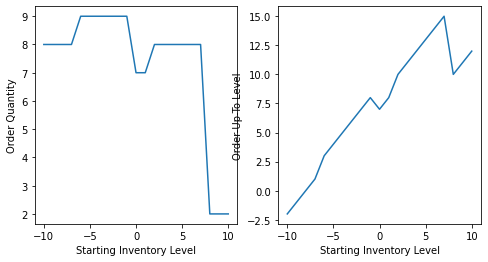

In [ ]:
plot_policy(env, dqn_policy)

This is nothing like a base-stock policy! It's possible for a non-optimal policy still to have good performance. This policy is only so-so; with better training, it remains to be seen how closely the learned policy will approximate a base-stock policy. 

(It's worth remembering that TD learning approximated the policy more closely. DQN is much more powerful but also requires much more extensive training.)

### Next Up

